In [1]:
import sys
sys.path.append('/home/alina/repos/Audio-Classification-HF/')

import torch
import numpy as np

from datasets import DatasetDict, load_dataset, load_metric, concatenate_datasets
from transformers import (
    Wav2Vec2Processor,
    set_seed
)

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._

In [2]:
set_seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [4]:
dataset = load_dataset("xbgoose/dusha")

ds_ang = dataset['train'].filter(lambda example: example["emotion"] == "angry")
ds_hap = dataset['train'].filter(lambda example: example["emotion"] == "positive")
ds_sad = dataset['train'].filter(lambda example: example["emotion"] == "sad")
ds_neu = dataset['train'].filter(lambda example: example["emotion"] == "neutral")
ds_oth = dataset['train'].filter(lambda example: example["emotion"] == "other")

ds_a = ds_ang.shard(num_shards=4, index=0)
ds_h = ds_hap.shard(num_shards=4, index=0)
ds_s = ds_sad.shard(num_shards=6, index=0)
ds_n = ds_neu.shard(num_shards=30, index=0)
ds_o = ds_oth

ds = concatenate_datasets([ds_a, ds_h, ds_s, ds_n, ds_o])

train_testvalid = ds.train_test_split(shuffle=True, test_size=0.1, seed=42)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

In [5]:
dataset = DatasetDict(
    {
        "train": train_testvalid["train"],
        "test": test_valid["test"],
        "val": test_valid["train"],
    }
)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'emotion'],
        num_rows: 14171
    })
    test: Dataset({
        features: ['audio', 'emotion'],
        num_rows: 788
    })
    val: Dataset({
        features: ['audio', 'emotion'],
        num_rows: 787
    })
})

In [7]:
dataset = dataset.class_encode_column("emotion")

labels = dataset["train"].features["emotion"].names

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(id2label)

{'0': 'angry', '1': 'neutral', '2': 'other', '3': 'positive', '4': 'sad'}


In [8]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [9]:
INPUT_FIELD = "input_values"
LABEL_FIELD = "labels"

def prepare_dataset(examples, processor):
    audio_arrays = [x["array"] for x in examples["audio"]]
    input = processor(
        audio_arrays, 
        sampling_rate=16000, 
        padding=True,
        return_tensors="pt"
    )

    examples[INPUT_FIELD] = input.input_values.to(device)
    examples[LABEL_FIELD] = examples[ "emotion"]  # colname MUST be labels as Trainer will look for it by default

    return examples

encoded_dataset = dataset.map(prepare_dataset, 
                              fn_kwargs={"processor": processor}, 
                              remove_columns=["audio"],
                              batched=True, 
                              batch_size=1)

In [10]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

In [11]:
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


In [13]:
class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """
    
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [14]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

is_regression = False

In [15]:
metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


/tmp/ipykernel_465497/4076445278.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [16]:
model_name_or_path = "./models/wav2vec_04_exp/audio-model"
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path
).to(device)

In [17]:
from tqdm import tqdm

model.eval()
preds = []
for sample in tqdm(encoded_dataset['test']):
    logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
    predictions = torch.argmax(logits, dim=-1)
    predicted_emotion = model.config.id2label[predictions.cpu().data.numpy()[0]]
    preds.append(predicted_emotion)


  0%|          | 0/788 [00:00<?, ?it/s]/tmp/ipykernel_465497/4237719857.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/tensor/python_tensor.cpp:83.)
  logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
100%|██████████| 788/788 [00:56<00:00, 13.88it/s]


In [18]:
gts  = [model.config.id2label[gt] for gt in encoded_dataset['test']['labels']]

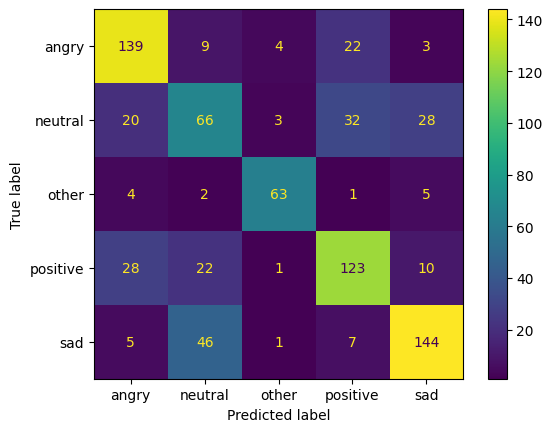

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds, labels=list(model.config.label2id.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(model.config.label2id.keys()))
disp.plot()

plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(gts, preds, target_names=list(model.config  .label2id.keys())))

              precision    recall  f1-score   support

       angry       0.71      0.79      0.75       177
     neutral       0.46      0.44      0.45       149
       other       0.88      0.84      0.86        75
    positive       0.66      0.67      0.67       184
         sad       0.76      0.71      0.73       203

    accuracy                           0.68       788
   macro avg       0.69      0.69      0.69       788
weighted avg       0.68      0.68      0.68       788



: 